In [1]:
import sys
#sys.path.insert(0,'./src/')
#simulator_path = "../covid_de/sim/" ##change simulatio path here 
sys.path.insert(0,'src/')
sys.path.insert(0, '../sib/')
simulator_path = "../simulator/sim/" ##change simulatio path here 
sys.path.insert(0, '../simulator/sim/lib/') # we need distributions.py
sys.path.insert(0,simulator_path)
sys.path.insert(0, "../epidemic_mitigation/src/") # correct rankers

from pathlib import Path
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import json, log, logging, loop_mtpp
from importlib import reload
import imp
from math import exp
import pickle
#sys.path.insert(0,'./src/loop_ranker')
from lib.mobilitysim import MobilitySimulator
import loop_mtpp
from mtpp_utils import contacts_cg
from distributions import CovidDistributions



#logging
data_path = '../simulator/sim/lib/mobility/'

output_dir = "output_Tubingen_pop1_site1/"
fold_out = Path(output_dir)
if not fold_out.exists():
    fold_out.mkdir(parents=True)

reload(log)
logger = log.setup_logger()

Log setup complete


### Mobility simulation

In [2]:
beta = 0.05 # from paper
country = 'GER'
distr = CovidDistributions(country)
#with open(data_path + 'Isle_of_Wight_settings_pop10_site5.pk', 'rb') as fp:
with open(data_path + 'Tubingen_settings_pop1_site1.pk', 'rb') as fp:
    mob_kwargs = pickle.load(fp)

mob_kwargs["delta"] = 0.2554120904376099
T = 5
seed_mob = 2
seed = 1
t_unit = 24
t_res = 0.25 # drop contacts with a duration < t_res (in hours)
max_time = T * t_unit  
mob = MobilitySimulator(**mob_kwargs)
mob.verbose = True
out = mob.simulate(max_time=max_time, seed=seed_mob)
N = mob.num_people 
#print(N)

Simulate mobility for 120.00 time units... 

In [3]:
#contacts_df = pd.DataFrame(contacts_cg(mob, t_res, t_unit, 0, np.inf, first_filter = False),columns = ['i','j','t','deltat'])

In [4]:
#contacts_df = contacts_df.sort_values(by=["t","i","j"])

## Set testing and quarantine rules

In [5]:
#n_indiv=np.ceil(mob_kwargs['num_people_unscaled']/mob_kwargs['downsample_pop'])
n_seeds = {'expo': 3, 'iasy':4,'ipre':5} # select initial infected seeds
num_test_random = 0 #number of random tests per day
fraction_sym_obs = 0.5 #fraction of Symptomatic tested positive
initial_steps = 2 #starting time of intervention
delta_days = 1 # intervention every delta_days days
#assert initial_steps % delta_days == 0
test_HH = False
quarantine_HH = True
adoption_fraction = 1.0
probability_th = 0.00
adapt_th = True

## Set the inference algorithm class

In [6]:
import sib,  scipy

from rankers import sib_rank, dotd_rank, mean_field_rank, tracing_rank
from tqdm.notebook import tqdm
from scipy.stats import gamma
sib.set_num_threads(6)

import matplotlib.pyplot as plt

mu = 1/12
prob_seed = 1/N
prob_sus = 0.5
pseed = prob_seed / (2 - prob_seed)
psus = prob_sus * (1 - pseed)
pautoinf = 1e-6
fp_rate = 0.0
fn_rate = 0.0

rankers = {}
#rankers["dotd"] = dotd_rank.DotdRanker()

"""
rankers["MF"] = mean_field_rank.MeanFieldRanker(
                tau = 5,
                delta = 10,
                mu = mu,
                lamb = 1.0
                )
                

rankers["tracing"] = tracing_rank.TracingRanker(
                 tau=5,
                 lamb=1.0
)


rankers["greedy"] = greedy_rank.GreedyRanker(
                 include_S = True,
                tau=10)



rankers["winbp20prob0"] = winbp_prob0_rank.WinBPProb0Ranker(
                 params = sib.Params(
                                 prob_i = sib.Uniform(1.0),
                                 prob_r = sib.Exponential(mu=mu),
                                 #prob_i = sib.PriorDiscrete(list(0.25 * abm_utils.gamma_pdf_array(T+1,6,2.5))),
                                 #prob_r = sib.PriorDiscrete(list(scipy.stats.gamma.sf(range(T+1), 10., scale=1.7452974337097158))),
                                 #prob_i = sib.Uniform(0.014),
                                 #prob_r = sib.Gamma(k = 10, mu = 1/1.7452974337097158),
                                 pseed = pseed,
                                 psus = psus,
                                 fp_rate = fp_rate,
                                 fn_rate = fn_rate,
                                 pautoinf = pautoinf),
                 maxit0 = 30,
                 maxit1 = 30,
                 damp0 = 0.5,
                 damp1 = 0.9,
                 tol = 1e-3,
                 memory_decay = 1e-2,
                 window_length = 20
)


rankers["no_intervention"] = None
"""
k_rec_gamma = 62.484380808876004
scale_rec_gamma = 0.2992112296058585
t0 = distr.incubation_mean_of_lognormal - distr.median_infectious_without_symptom
alpha = 2.0
tau =  7

rankers["sib"] = sib_rank.SibRanker(
                 params = sib.Params(
                                 #prob_i = sib.Cached(sib.Scaled(sib.PDF(sib.Gamma(k=5.76, mu=0.96)), scale=0.25), T+1),
                                 #prob_r = sib.Cached(sib.Gamma(k = 10, mu = 1/1.7452974337097158), T+1),
                                 prob_i = sib.PiecewiseLinear(sib.RealParams(list(scipy.special.expit(alpha*(range(T+1) -t0*np.ones(T+1)))))), 
                                 prob_r = sib.PiecewiseLinear(sib.RealParams(list(scipy.stats.gamma.sf(range(T+1), k_rec_gamma, scale=scale_rec_gamma)))),
                                 pseed = pseed,
                                 psus = psus,
                                 fp_rate = fp_rate,
                                 fn_rate = fn_rate,
                                 pautoinf = pautoinf),
                 maxit0 = 20,
                 maxit1 = 20,
                 tol = 1e-3,
                 memory_decay = 1e-5,
                 window_length = 21,
                 tau=tau
)

"""
rankers["winbp21_tau0"] = winbp_prob0_rank.WinBPProb0Ranker(
                 params = sib.Params(
                                 prob_i = sib.Cached(sib.Scaled(sib.PDF(sib.Gamma(k=5.76, mu=0.96)), scale=0.25), T+1),
                                 prob_r = sib.Cached(sib.Gamma(k = 10, mu = 1/1.7452974337097158), T+1),
                                 pseed = pseed,
                                 psus = psus,
                                 fp_rate = fp_rate,
                                 fn_rate = fn_rate,
                                 pautoinf = pautoinf),
                 maxit0 = 20,
                 maxit1 = 20,
                 tol = 1e-3,
                 memory_decay = 1e-5,
                 window_length = 21,
                 tau=0
)


rankers["winbp21_uninf"] = winbp_prob0_rank.WinBPProb0Ranker(
                 params = sib.Params(
                                 prob_i = sib.Uniform(1.0), 
                                 prob_r = sib.Exponential(0.1), 
                                 pseed = pseed,
                                 psus = psus,
                                 fp_rate = fp_rate,
                                 fn_rate = fn_rate,
                                 pautoinf = pautoinf),
                 maxit0 = 20,
                 maxit1 = 20,
                 tol = 1e-3,
                 memory_decay = 1e-5,
                 window_length = 21,
                 tau=7
)

"""

'\nrankers["winbp21_tau0"] = winbp_prob0_rank.WinBPProb0Ranker(\n                 params = sib.Params(\n                                 prob_i = sib.Cached(sib.Scaled(sib.PDF(sib.Gamma(k=5.76, mu=0.96)), scale=0.25), T+1),\n                                 prob_r = sib.Cached(sib.Gamma(k = 10, mu = 1/1.7452974337097158), T+1),\n                                 pseed = pseed,\n                                 psus = psus,\n                                 fp_rate = fp_rate,\n                                 fn_rate = fn_rate,\n                                 pautoinf = pautoinf),\n                 maxit0 = 20,\n                 maxit1 = 20,\n                 tol = 1e-3,\n                 memory_decay = 1e-5,\n                 window_length = 21,\n                 tau=0\n)\n\n\nrankers["winbp21_uninf"] = winbp_prob0_rank.WinBPProb0Ranker(\n                 params = sib.Params(\n                                 prob_i = sib.Uniform(1.0), \n                                 prob_r = sib.E

In [7]:
mob.delta

0.2554120904376099

In [8]:
ress = {}
for num_test_algo in [300]: #number of test per day by ranking
    for seed in [0]:
        print(num_test_algo, seed)
        for s in list(rankers.keys()):
            data = {"algo":s}
            if s== "no_intervention":
                    res_s = loop_mtpp.free_mtpp(mob,
                    country  = country,
                    beta = beta,
                    T = T,
                    seed=seed,
                    logger = logging.getLogger(f"iteration.{s}"),
                    data = data,
                    initial_counts = n_seeds,
                    name_file_res = s + f"_N_{N}_T_{T}_obs_{num_test_algo}_sym_obs_{fraction_sym_obs}_seed_{seed}",
                    output_dir = output_dir,
                     )
            else:
                    res_s = loop_mtpp.loop_mtpp(mob,
                    rankers[s],
                    country  = country,
                    T = T,
                    seed=seed,
                    logger = logging.getLogger(f"iteration.{s}"),
                    data = data,
                    initial_steps = initial_steps, 
                    num_test_random = num_test_random,
                    num_test_algo = num_test_algo,
                    fraction_sym_obs = fraction_sym_obs,
                    initial_counts = n_seeds,
                    beta = beta,
                    test_HH = test_HH,
                    quarantine_HH = quarantine_HH,
                    name_file_res = s + f"_N_{N}_T_{T}_obs_{num_test_algo}_sym_obs_{fraction_sym_obs}_seed_{seed}",
                    output_dir = output_dir,
                    save_every_iter = 1,
                    adoption_fraction = adoption_fraction,
                    probability_th = probability_th,
                    adapt_th = adapt_th,
                    fp_rate = fp_rate,
                    fn_rate = fn_rate
                 )
            ress[s] = res_s    
        del res_s


300 0
Starting with guys:  {'expo': [2529, 14544, 47560], 'iasy': [23291, 62890, 63479, 90427], 'ipre': [19479, 72336, 49207, 59093, 82846]}
t: 24.00 | 120.00 hrs (5 d)

iteration.sib: INFO     time:0



[Reached max time: 24h (1d)]
All raw contacts 990322
Contacts at midnight  35418
Contacts collected by coarse-graining  19636
Contacts in multiple days  0
Coarse-grained contacts  1006104
Missing contacts  0
Asymmetric contacts  0


numexpr.utils: INFO     Note: detected 72 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
numexpr.utils: INFO     Note: NumExpr detected 72 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
numexpr.utils: INFO     NumExpr defaulting to 8 threads.
iteration.sib: INFO     adding contacts in the interval [0, 24]
iteration.sib: INFO     number of unique contacts: 970686


sib.iterate(damp=0):  2/20 1.110e-15/0.001        
sib.iterate(damp=0.5):  0/20 7.772e-16/0.001    


iteration.sib: INFO     winBP: (S,I,R): (90538.0, 1.0, 0.0), seeds: 1.0, ll: -62756.4
iteration.sib: INFO     number of tests today: 0
iteration.sib: INFO     True  : (S,I,R): (90527.0, 12.0, 0.0)
iteration.sib: INFO     AUR_I : 0.462, prec100: 0, prec(1% of 90540): 0.00, prec5%: 0.00
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 0 guys -> got 0 infected, 12 free as birds (+12)


t: 48.00 | 120.00 hrs (5 d)

iteration.sib: INFO     time:1



[Reached max time: 48h (2d)]
All raw contacts 1079942
Contacts at midnight  71042
Contacts collected by coarse-graining  22620
Contacts in multiple days  0
Coarse-grained contacts  1128364
Missing contacts  0
Asymmetric contacts  0


iteration.sib: INFO     adding contacts in the interval [24, 48]
iteration.sib: INFO     number of unique contacts: 1057322


sib.iterate(damp=0):  2/20 1.442e-12/0.001        
sib.iterate(damp=0.5):  0/20 1.998e-15/0.001    


iteration.sib: INFO     winBP: (S,I,R): (90537.9, 1.1, 0.0), seeds: 1.0, ll: -62756.4
iteration.sib: INFO     number of tests today: 0
iteration.sib: INFO     True  : (S,I,R): (90524.0, 15.0, 0.0)
iteration.sib: INFO     AUR_I : 0.431, prec100: 0, prec(1% of 90540): 0.00, prec5%: 0.00
iteration.sib: INFO     sym: 1, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 2 guys -> got 1 infected, 14 free as birds (+2)


t: 72.00 | 120.00 hrs (5 d)

iteration.sib: INFO     
observation-based inference algorithm starts now

iteration.sib: INFO     time:2



[Reached max time: 72h (3d)]
All raw contacts 1094472
Contacts at midnight  68930
Contacts collected by coarse-graining  23316
Contacts in multiple days  0
Coarse-grained contacts  1140086
Missing contacts  0
Asymmetric contacts  0


iteration.sib: INFO     adding contacts in the interval [48, 72]
iteration.sib: INFO     number of unique contacts: 1071156


sib.iterate(damp=0):  2/20 1.221e-11/0.001            
sib.iterate(damp=0.5):  0/20 2.704e-15/0.001    


iteration.sib: INFO     winBP: (S,I,R): (90536.8, 2.2, 0.0), seeds: 1.9, ll: -62767.7
iteration.sib: INFO     number of tests today: 2
iteration.sib: INFO     True  : (S,I,R): (90523.0, 16.0, 0.0)
iteration.sib: INFO     AUR_I : 0.504, prec100: 0, prec(1% of 90538): 0.00, prec5%: 0.00
iteration.sib: INFO     sym: 1, results test algo (S,I,R): (2,0,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 3 guys -> got 1 infected, 14 free as birds (+0)


t: 96.00 | 120.00 hrs (5 d)

iteration.sib: INFO     time:3



[Reached max time: 96h (4d)]
All raw contacts 1078168
Contacts at midnight  67594
Contacts collected by coarse-graining  23578
Contacts in multiple days  0
Coarse-grained contacts  1122184
Missing contacts  0
Asymmetric contacts  0


iteration.sib: INFO     adding contacts in the interval [72, 96]
iteration.sib: INFO     number of unique contacts: 1054400


sib.iterate(damp=0):  2/20 3.160e-10/0.001        
sib.iterate(damp=0.5):  0/20 1.311e-13/0.001    


iteration.sib: INFO     winBP: (S,I,R): (90535.7, 3.3, 0.0), seeds: 2.8, ll: -62778.9
iteration.sib: INFO     number of tests today: 1
iteration.sib: INFO     True  : (S,I,R): (90523.0, 16.0, 0.0)
iteration.sib: INFO     AUR_I : 0.704, prec100: 0, prec(1% of 90535): 0.00, prec5%: 0.00
iteration.sib: INFO     sym: 2, results test algo (S,I,R): (1,0,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 7 guys -> got 3 infected, 11 free as birds (-3)


t: 119.90 | 120.00 hrs (5 d)

iteration.sib: INFO     time:4


All raw contacts 984892
Contacts at midnight  34288
Contacts collected by coarse-graining  18868
Contacts in multiple days  0
Coarse-grained contacts  1000312
Missing contacts  0
Asymmetric contacts  0


iteration.sib: INFO     adding contacts in the interval [96, 120]
iteration.sib: INFO     number of unique contacts: 965782


sib.iterate(damp=0):  2/20 1.097e-05/0.001        
sib.iterate(damp=0.5):  0/20 8.957e-07/0.001    


iteration.sib: INFO     winBP: (S,I,R): (90532.5, 6.5, 0.0), seeds: 5.1, ll: -62812.4
iteration.sib: INFO     number of tests today: 6
iteration.sib: INFO     True  : (S,I,R): (90518.0, 21.0, 0.0)
iteration.sib: INFO     AUR_I : 0.600, prec100: 3, prec(1% of 90528): 0.00, prec5%: 0.00
iteration.sib: INFO     sym: 1, results test algo (S,I,R): (6,0,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 5 guys -> got 1 infected, 15 free as birds (+4)


Time  219.5606129169464


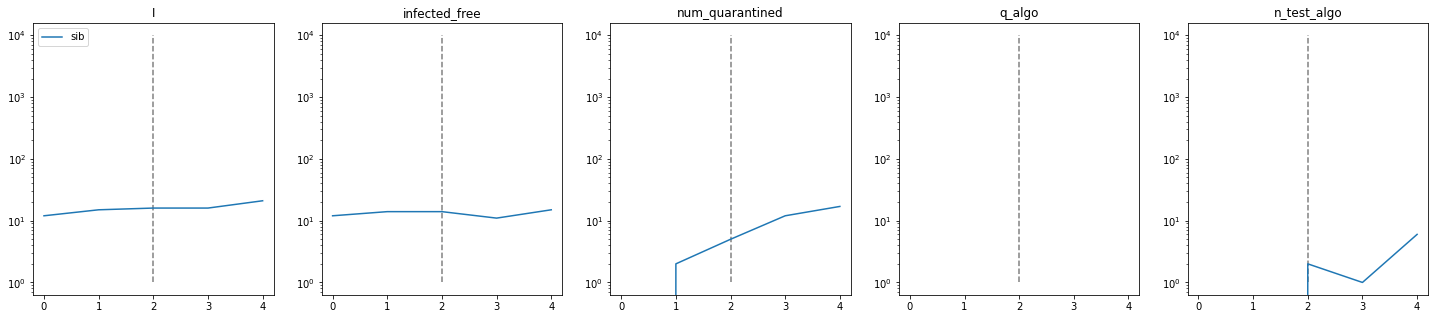

In [9]:
import matplotlib.pyplot as plt
fig,axs = plt.subplots(1,5,figsize = (25,5))
to_plot = ['I','infected_free','num_quarantined', "q_algo", "n_test_algo"]
for s in ress.keys():    
    for il,l in enumerate(to_plot):
        if s != "no_intervention":
            axs[il].plot(range(T),ress[s][l],label = s)
            if l!= "aurI":
                axs[il].set_yscale ("log") 
                axs[il].vlines(initial_steps,ymin = 1,ymax = 10**4,linestyle = "--",alpha = 0.5, color = "black")
            else:
                axs[il].vlines(initial_steps,ymin = 0,ymax = 1,linestyle = "--",alpha = 0.5, color = "black")
            
            axs[il].set_title(l,fontsize = 12)
    axs[0].legend(loc = 'upper left')
    
#fig.suptitle(f"num test algo {num_test_algo} - adoption_fraction {adoption_fraction}")
fig.show()




In [10]:
len(ress['sib']['tested_algo'][0])

0

In [11]:
a = ress['sib']['tested_algo'][0]
print(a[10899])

IndexError: list index out of range

In [ ]:
df = pd.DataFrame.from_records(ress["sib"])
df.to_csv("prova.gz")

In [ ]:
res = pd.read_csv("prova.gz", usecols = ["tested_algo"], dtype = int)